# Oracle & Orderbook Analysis

This notebook loads oracle and orderbook data from sim_data subdirectories, reconstructs orderbooks at each oracle timestamp, and creates a global DataFrame with:
- **MidPriceUp**: Mid price of the UP token orderbook
- **MidPriceDown**: Mid price of the DOWN token orderbook
- **BpsDifference**: `(price - threshold) / threshold * 10_000` from oracle data

In [22]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt

In [23]:
import bisect

class OrderbookReconstructor:
    """Reconstructs orderbook state from initial snapshot and incremental price changes."""
    
    def __init__(self, up_token_id: str, down_token_id: str, initial_snapshots: dict):
        self.up_token_id = up_token_id
        self.down_token_id = down_token_id
        
        # Initialize orderbooks from snapshots
        # Structure: {token_id: {'bids': {price: size}, 'asks': {price: size}}}
        self.orderbooks = {}
        for token_id, snapshot in initial_snapshots.items():
            self.orderbooks[token_id] = {
                'bids': {item['price']: item['size'] for item in snapshot.get('bids', [])},
                'asks': {item['price']: item['size'] for item in snapshot.get('asks', [])}
            }
    
    def apply_single_change(self, change: dict):
        """Apply a single price change to the orderbook."""
        asset_id = change['asset_id']
        price = change['price']
        size = change['size']
        side = 'bids' if change['side'] == 'buy' else 'asks'
        
        if asset_id not in self.orderbooks:
            self.orderbooks[asset_id] = {'bids': {}, 'asks': {}}
        
        if size == 0:
            # Remove price level
            self.orderbooks[asset_id][side].pop(price, None)
        else:
            # Update or add price level
            self.orderbooks[asset_id][side][price] = size
    
    def get_mid_price(self, token_id: str) -> Optional[float]:
        """Get mid price for a token: (best_bid + best_ask) / 2."""
        if token_id not in self.orderbooks:
            return None
        
        ob = self.orderbooks[token_id]
        bids = ob.get('bids', {})
        asks = ob.get('asks', {})
        
        if not bids or not asks:
            return None
        
        best_bid = max(bids.keys())
        best_ask = min(asks.keys())
        
        return (best_bid + best_ask) / 2
    
    def get_mid_price_up(self) -> Optional[float]:
        return self.get_mid_price(self.up_token_id)
    
    def get_mid_price_down(self) -> Optional[float]:
        return self.get_mid_price(self.down_token_id)

In [24]:
def process_sim_directory(dir_path: Path) -> pd.DataFrame:
    """Process a single sim_data subdirectory and return DataFrame with MidPriceUp, MidPriceDown, BpsDifference.
    
    Iterates over every price_change (ms precision) and looks up the corresponding oracle entry
    (most recent oracle with timestamp <= change timestamp) for each change.
    """
    oracle_path = dir_path / 'oracle.json'
    orderbooks_path = dir_path / 'orderbooks_raw.json'
    
    if not oracle_path.exists() or not orderbooks_path.exists():
        print(f"Skipping {dir_path.name}: missing required files")
        return pd.DataFrame()
    
    # Load data
    with open(oracle_path, 'r') as f:
        oracle_data = json.load(f)
    
    with open(orderbooks_path, 'r') as f:
        orderbooks_data = json.load(f)
    
    # Sort oracle by timestamp for binary search lookup
    oracle_data = sorted(oracle_data, key=lambda x: x['timestamp'])
    oracle_timestamps = [e['timestamp'] for e in oracle_data]
    
    # Sort price_changes by timestamp
    price_changes = sorted(orderbooks_data.get('price_changes', []), key=lambda x: x['timestamp'])
    
    # Initialize orderbook reconstructor from initial snapshots only
    reconstructor = OrderbookReconstructor(
        up_token_id=orderbooks_data['up_token_id'],
        down_token_id=orderbooks_data['down_token_id'],
        initial_snapshots=orderbooks_data['initial_snapshots']
    )
    
    rows = []
    for change in price_changes:
        change_ts = change['timestamp']
        
        # Apply this change to orderbook
        reconstructor.apply_single_change(change)
        
        # Find oracle entry valid at this timestamp (binary search)
        # bisect_right returns insertion point, so -1 gives us the last oracle <= change_ts
        oracle_idx = bisect.bisect_right(oracle_timestamps, change_ts) - 1
        if oracle_idx < 0:
            continue  # No oracle data yet
        
        oracle_entry = oracle_data[oracle_idx]
        
        # Calculate mid prices from current orderbook state
        mid_price_up = reconstructor.get_mid_price_up()
        mid_price_down = reconstructor.get_mid_price_down()
        
        # Calculate BpsDifference from oracle
        bps_diff = (oracle_entry['price'] - oracle_entry['threshold']) / oracle_entry['threshold'] * 10_000
        
        rows.append({
            'timestamp': change_ts,
            'MidPriceUp': mid_price_up,
            'MidPriceDown': mid_price_down,
            'OraclePrice': oracle_entry['price'],
            'Threshold': oracle_entry['threshold'],
            'BpsDifference': bps_diff,
            'source_dir': dir_path.name
        })
    
    return pd.DataFrame(rows)

In [25]:
# Main processing loop - load data from all sim_data subdirectories
# Path relative to src/model_tuning/ directory
sim_data_path = Path('../../sim_data')

all_dfs = []
for subdir in sorted(sim_data_path.iterdir()):
    if subdir.is_dir():
        print(f"Processing {subdir.name}...")
        df = process_sim_directory(subdir)
        if not df.empty:
            all_dfs.append(df)
            print(f"  -> {len(df)} rows")

# Concatenate all DataFrames
if all_dfs:
    global_df = pd.concat(all_dfs, ignore_index=True)
    rows_initial = len(global_df)
    
    # First pass: Remove exact duplicate rows (all columns including timestamp)
    global_df = global_df.drop_duplicates()
    rows_after_exact = len(global_df)
    
    # Second pass: Remove duplicates based on all columns except timestamp
    # Keep the first occurrence (earliest timestamp)
    cols_for_dedup = [c for c in global_df.columns if c != 'timestamp']
    global_df = global_df.drop_duplicates(subset=cols_for_dedup, keep='first')
    rows_final = len(global_df)
    
    print(f"\nTotal rows initial: {rows_initial}")
    print(f"After exact deduplication: {rows_after_exact} (removed {rows_initial - rows_after_exact})")
    print(f"After content deduplication: {rows_final} (removed {rows_after_exact - rows_final})")
else:
    global_df = pd.DataFrame()
    print("No data found")

Processing btc-updown-15m-1768633200...
  -> 114592 rows
Processing btc-updown-15m-1768634100...
  -> 113408 rows
Processing btc-updown-15m-1768635000...
  -> 106422 rows
Processing btc-updown-15m-1768635900...
  -> 112752 rows
Processing btc-updown-15m-1768636800...
  -> 109906 rows
Processing btc-updown-15m-1768637700...
  -> 136134 rows
Processing btc-updown-15m-1768639500...
  -> 132464 rows
Processing eth-updown-15m-1768633200...
  -> 66234 rows
Processing eth-updown-15m-1768634100...
  -> 96782 rows
Processing eth-updown-15m-1768635000...
  -> 97322 rows
Processing eth-updown-15m-1768635900...
  -> 101416 rows
Processing eth-updown-15m-1768636800...
  -> 81466 rows
Processing eth-updown-15m-1768637700...
  -> 110194 rows
Processing eth-updown-15m-1768638600...
  -> 117454 rows
Processing eth-updown-15m-1768639500...
  -> 93336 rows

Total rows initial: 1589882
After exact deduplication: 723442 (removed 866440)
After content deduplication: 22666 (removed 700776)


In [26]:
# Display DataFrame info and first rows
print("DataFrame columns:", global_df.columns.tolist())
print(f"\nShape: {global_df.shape}")
print(f"\nData types:\n{global_df.dtypes}")
print(f"\nFirst 10 rows:")
global_df

DataFrame columns: ['timestamp', 'MidPriceUp', 'MidPriceDown', 'OraclePrice', 'Threshold', 'BpsDifference', 'source_dir']

Shape: (22666, 7)

Data types:
timestamp          int64
MidPriceUp       float64
MidPriceDown     float64
OraclePrice      float64
Threshold        float64
BpsDifference    float64
source_dir        object
dtype: object

First 10 rows:


,timestamp,MidPriceUp,MidPriceDown,OraclePrice,Threshold,BpsDifference,source_dir
0,1768633237079,0.435,0.565,95187.851022,95194.31,-0.678505,btc-updown-15m-1768633200
8,1768633237207,0.430,0.565,95187.851022,95194.31,-0.678505,btc-updown-15m-1768633200
9,1768633237207,0.430,0.570,95187.851022,95194.31,-0.678505,btc-updown-15m-1768633200
12,1768633237234,0.430,0.575,95187.851022,95194.31,-0.678505,btc-updown-15m-1768633200
13,1768633237234,0.425,0.575,95187.851022,95194.31,-0.678505,btc-updown-15m-1768633200
...,...,...,...,...,...,...,...
1589748,1768640380014,0.955,0.045,3295.102018,3293.32,5.411008,eth-updown-15m-1768639500
1589752,1768640381140,0.955,0.045,3295.118992,3293.32,5.462548,eth-updown-15m-1768639500
1589758,1768640382418,0.955,0.045,3295.126629,3293.32,5.485738,eth-updown-15m-1768639500
1589762,1768640383517,0.955,0.045,3295.184495,3293.32,5.661445,eth-updown-15m-1768639500


In [27]:
# Summary statistics
print("Summary Statistics:")
print("="*50)
global_df[['MidPriceUp', 'MidPriceDown', 'BpsDifference']].describe()

Summary Statistics:


,MidPriceUp,MidPriceDown,BpsDifference
count,22659.000000,22660.000000,22666.000000
mean,0.530030,0.470045,0.213371
std,0.245575,0.245598,4.547981
min,0.005500,0.015000,-14.551312
25%,0.320000,0.275000,-2.224698
50%,0.555000,0.445000,1.019601
75%,0.725000,0.680000,3.566006
max,0.985000,0.994500,9.203555


In [28]:
# Verify mid prices are in valid range (0-1)
print("Validation:")
print("="*50)
print(f"MidPriceUp range: [{global_df['MidPriceUp'].min():.4f}, {global_df['MidPriceUp'].max():.4f}]")
print(f"MidPriceDown range: [{global_df['MidPriceDown'].min():.4f}, {global_df['MidPriceDown'].max():.4f}]")
print(f"BpsDifference range: [{global_df['BpsDifference'].min():.2f}, {global_df['BpsDifference'].max():.2f}]")
print(f"\nNull values:")
print(global_df[['MidPriceUp', 'MidPriceDown', 'BpsDifference']].isnull().sum())

Validation:
MidPriceUp range: [0.0055, 0.9850]
MidPriceDown range: [0.0150, 0.9945]
BpsDifference range: [-14.55, 9.20]

Null values:
MidPriceUp       7
MidPriceDown     6
BpsDifference    0
dtype: int64


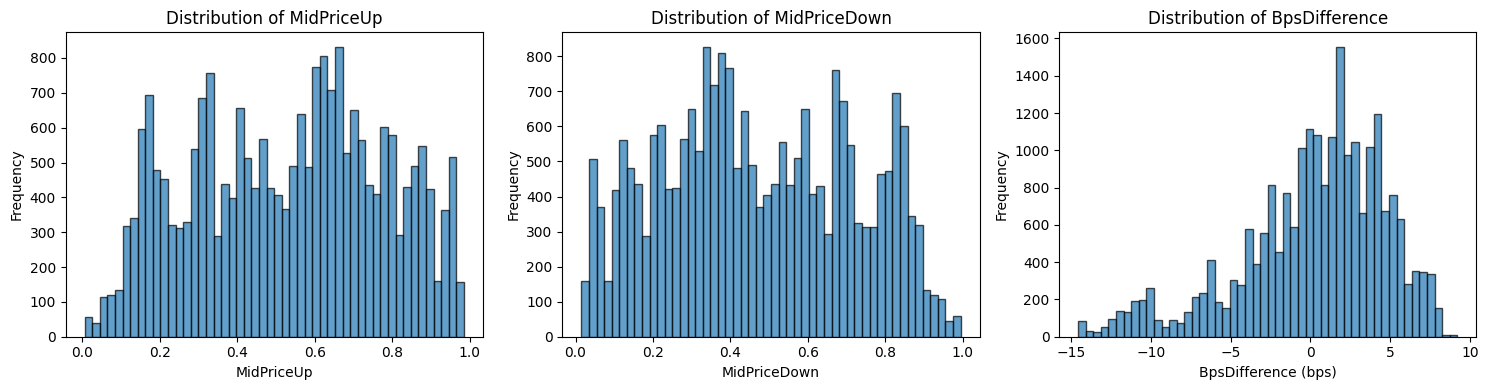

In [29]:
# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(global_df['MidPriceUp'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('MidPriceUp')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of MidPriceUp')

axes[1].hist(global_df['MidPriceDown'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('MidPriceDown')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of MidPriceDown')

axes[2].hist(global_df['BpsDifference'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('BpsDifference (bps)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of BpsDifference')

plt.tight_layout()
plt.show()

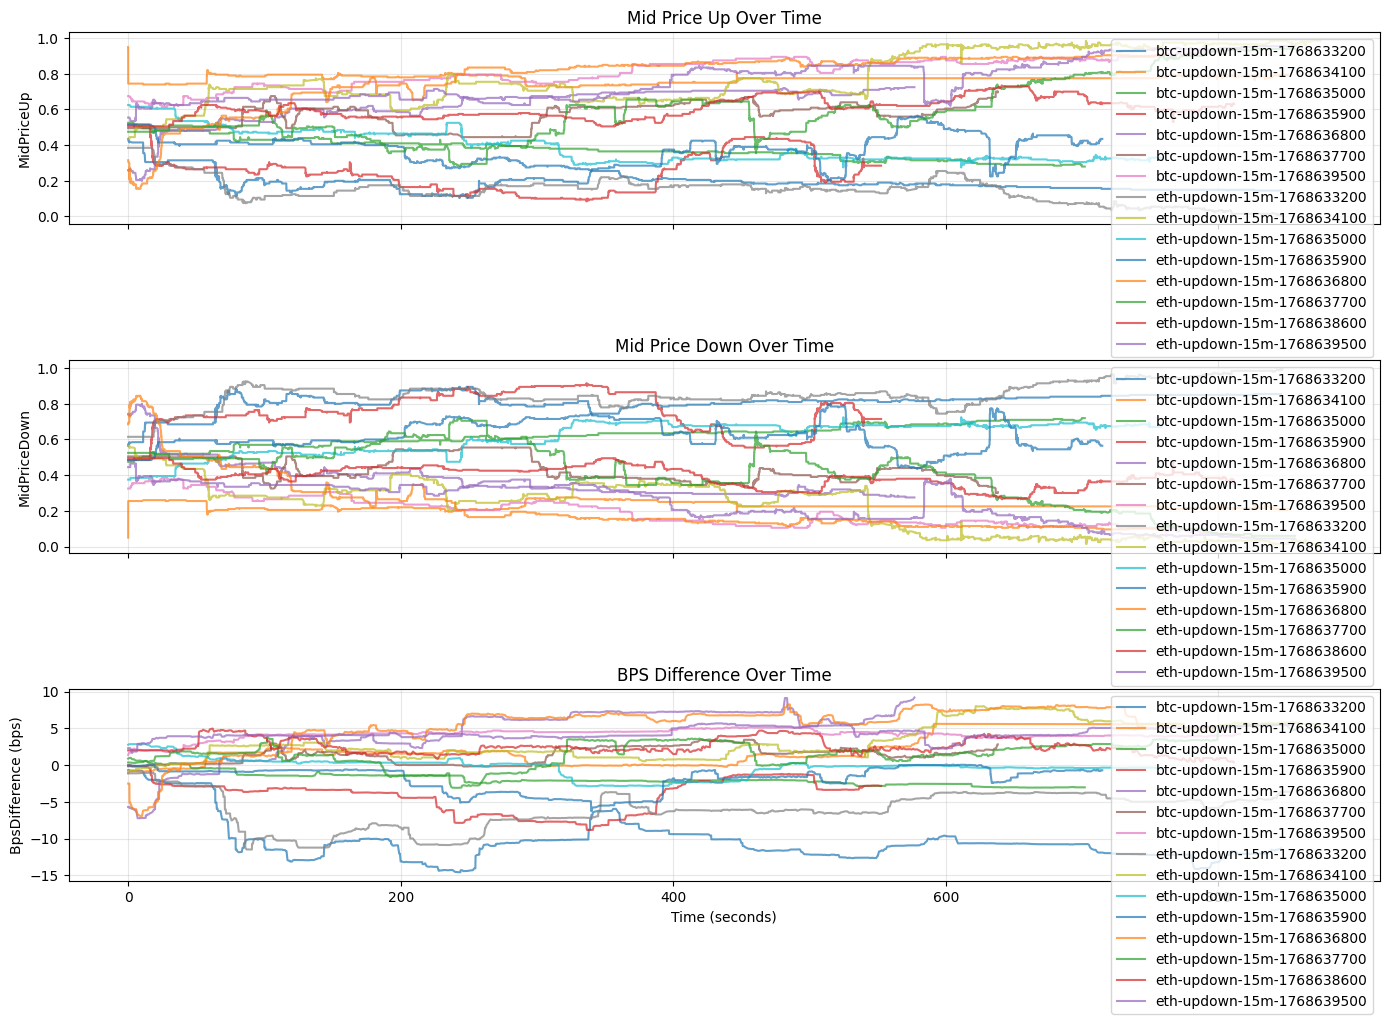

In [30]:
# Time series visualization (per source directory)
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for source in global_df['source_dir'].unique():
    subset = global_df[global_df['source_dir'] == source].copy()
    # Convert timestamp to relative seconds from start
    subset['time_sec'] = (subset['timestamp'] - subset['timestamp'].min()) / 1000
    
    axes[0].plot(subset['time_sec'], subset['MidPriceUp'], label=source, alpha=0.7)
    axes[1].plot(subset['time_sec'], subset['MidPriceDown'], label=source, alpha=0.7)
    axes[2].plot(subset['time_sec'], subset['BpsDifference'], label=source, alpha=0.7)

axes[0].set_ylabel('MidPriceUp')
axes[0].set_title('Mid Price Up Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_ylabel('MidPriceDown')
axes[1].set_title('Mid Price Down Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].set_ylabel('BpsDifference (bps)')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_title('BPS Difference Over Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## BpsDifference Boxplot Analysis

Analyze MidPriceUp and MidPriceDown behavior relative to BpsDifference bins.

In [31]:
# Step 1: Analyze BpsDifference distribution to determine optimal bin width

print("BpsDifference Distribution Analysis")
print("=" * 60)

# Count unique values
unique_bps = global_df['BpsDifference'].nunique()
print(f"\nUnique BpsDifference values: {unique_bps}")
print(f"Total samples: {len(global_df)}")

# Range
bps_min = global_df['BpsDifference'].min()
bps_max = global_df['BpsDifference'].max()
print(f"Range: [{bps_min:.2f}, {bps_max:.2f}] bps")

# Test different bin widths
print("\n" + "-" * 60)
print("Bin Width Analysis (target: 20+ samples per bin)")
print("-" * 60)

bin_widths = [0.5, 1, 2, 3, 4]
results = []

for width in bin_widths:
    # Create bins that cover the full range with buffer
    bin_edges = np.arange(np.floor(bps_min) - width, np.ceil(bps_max) + width, width)
    binned = pd.cut(global_df['BpsDifference'], bins=bin_edges)
    counts = binned.value_counts().sort_index()
    
    # Filter to non-empty bins
    non_empty = counts[counts > 0]
    
    results.append({
        'width': width,
        'num_bins': len(non_empty),
        'min_samples': non_empty.min(),
        'median_samples': non_empty.median(),
        'max_samples': non_empty.max(),
        'bins_below_20': (non_empty < 20).sum()
    })
    
    print(f"\nBin width: {width} bps")
    print(f"  Number of non-empty bins: {len(non_empty)}")
    print(f"  Samples per bin: min={non_empty.min():.0f}, median={non_empty.median():.0f}, max={non_empty.max():.0f}")
    print(f"  Bins with <20 samples: {(non_empty < 20).sum()}")

# Create summary DataFrame
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("Summary Table:")
print(results_df.to_string(index=False))

BpsDifference Distribution Analysis

Unique BpsDifference values: 9536
Total samples: 22666
Range: [-14.55, 9.20] bps

------------------------------------------------------------
Bin Width Analysis (target: 20+ samples per bin)
------------------------------------------------------------

Bin width: 0.5 bps
  Number of non-empty bins: 49
  Samples per bin: min=7, median=303, max=1538
  Bins with <20 samples: 3

Bin width: 1 bps
  Number of non-empty bins: 25
  Samples per bin: min=7, median=628, max=2622
  Bins with <20 samples: 1

Bin width: 2 bps
  Number of non-empty bins: 13
  Samples per bin: min=7, median=1009, max=4845
  Bins with <20 samples: 1

Bin width: 3 bps
  Number of non-empty bins: 9
  Samples per bin: min=7, median=1432, max=6926
  Bins with <20 samples: 1

Bin width: 4 bps
  Number of non-empty bins: 7
  Samples per bin: min=7, median=2692, max=8622
  Bins with <20 samples: 1

Summary Table:
 width  num_bins  min_samples  median_samples  max_samples  bins_below_20
  

In [32]:
# Step 2: Create binned BpsDifference column
# Using 2 bps bin width (adjust based on analysis above if needed)

BIN_WIDTH = 2  # bps

# Create bins covering the full range
bps_min = global_df['BpsDifference'].min()
bps_max = global_df['BpsDifference'].max()
bin_edges = np.arange(np.floor(bps_min / BIN_WIDTH) * BIN_WIDTH - BIN_WIDTH, 
                      np.ceil(bps_max / BIN_WIDTH) * BIN_WIDTH + BIN_WIDTH * 2, 
                      BIN_WIDTH)

# Create binned column
global_df['BpsBin'] = pd.cut(global_df['BpsDifference'], bins=bin_edges)

# Show bin distribution
bin_counts = global_df['BpsBin'].value_counts().sort_index()
print("Samples per BpsDifference bin:")
print("-" * 40)
for bin_label, count in bin_counts.items():
    if count > 0:
        print(f"  {bin_label}: {count:,} samples")

Samples per BpsDifference bin:
----------------------------------------
  (-16.0, -14.0]: 93 samples
  (-14.0, -12.0]: 292 samples
  (-12.0, -10.0]: 753 samples
  (-10.0, -8.0]: 352 samples
  (-8.0, -6.0]: 1,004 samples
  (-6.0, -4.0]: 947 samples
  (-4.0, -2.0]: 2,600 samples
  (-2.0, 0.0]: 3,185 samples
  (0.0, 2.0]: 4,703 samples
  (2.0, 4.0]: 4,107 samples
  (4.0, 6.0]: 3,191 samples
  (6.0, 8.0]: 1,368 samples
  (8.0, 10.0]: 71 samples


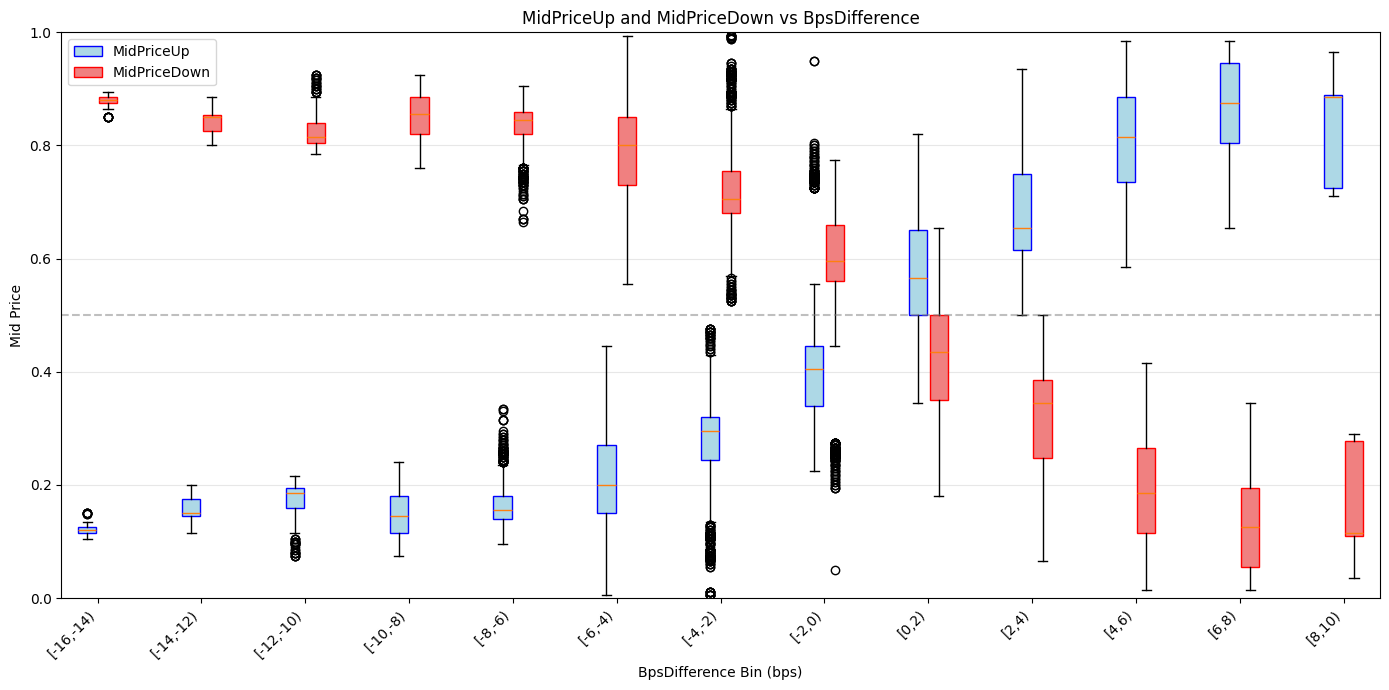


Sample counts per bin:
--------------------------------------------------
  [-16,-14)   :    93 samples  ⚠ Low
  [-14,-12)   :   292 samples  ✓ Good
  [-12,-10)   :   753 samples  ✓ Good
  [-10,-8)    :   352 samples  ✓ Good
  [-8,-6)     : 1,004 samples  ✓ Good
  [-6,-4)     :   947 samples  ✓ Good
  [-4,-2)     : 2,593 samples  ✓ Good
  [-2,0)      : 3,185 samples  ✓ Good
  [0,2)       : 4,703 samples  ✓ Good
  [2,4)       : 4,107 samples  ✓ Good
  [4,6)       : 3,191 samples  ✓ Good
  [6,8)       : 1,368 samples  ✓ Good
  [8,10)      :    71 samples  ⚠ Low


In [33]:
# Step 3: Create combined boxplot - MidPriceUp and MidPriceDown vs BpsDifference bins

# Prepare data - filter out NaN values and sort by bin
df_plot = global_df.dropna(subset=['MidPriceUp', 'MidPriceDown', 'BpsBin']).copy()
df_plot = df_plot.sort_values('BpsBin')

# Get ordered bin labels for x-axis
ordered_bins = sorted(df_plot['BpsBin'].dropna().unique())
bin_labels = [f"[{b.left:.0f},{b.right:.0f})" for b in ordered_bins]
n_bins = len(ordered_bins)

# Calculate sample counts per bin
sample_counts = df_plot.groupby('BpsBin', observed=True).size()

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Position parameters for side-by-side boxplots
positions_up = np.arange(n_bins) * 2 - 0.2
positions_down = np.arange(n_bins) * 2 + 0.2
width = 0.35

# Boxplot for MidPriceUp
bp_up = ax.boxplot(
    [df_plot[df_plot['BpsBin'] == b]['MidPriceUp'].values for b in ordered_bins],
    positions=positions_up,
    widths=width,
    patch_artist=True
)
for patch in bp_up['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('blue')

# Boxplot for MidPriceDown
bp_down = ax.boxplot(
    [df_plot[df_plot['BpsBin'] == b]['MidPriceDown'].values for b in ordered_bins],
    positions=positions_down,
    widths=width,
    patch_artist=True
)
for patch in bp_down['boxes']:
    patch.set_facecolor('lightcoral')
    patch.set_edgecolor('red')

# Formatting
ax.set_xticks(np.arange(n_bins) * 2)
ax.set_xticklabels(bin_labels, rotation=45, ha='right')
ax.set_xlabel('BpsDifference Bin (bps)')
ax.set_ylabel('Mid Price')
ax.set_title('MidPriceUp and MidPriceDown vs BpsDifference')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Legend
ax.legend([bp_up['boxes'][0], bp_down['boxes'][0]], ['MidPriceUp', 'MidPriceDown'], loc='upper left')

plt.tight_layout()
plt.show()

# Print sample counts below plot
print("\nSample counts per bin:")
print("-" * 50)
for b in ordered_bins:
    count = sample_counts.get(b, 0)
    label = f"[{b.left:.0f},{b.right:.0f})"
    confidence = "✓ Good" if count >= 100 else ("⚠ Low" if count >= 20 else "✗ Very low")
    print(f"  {label:12s}: {count:5,} samples  {confidence}")